In [81]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


[*********************100%***********************]  5 of 5 completed


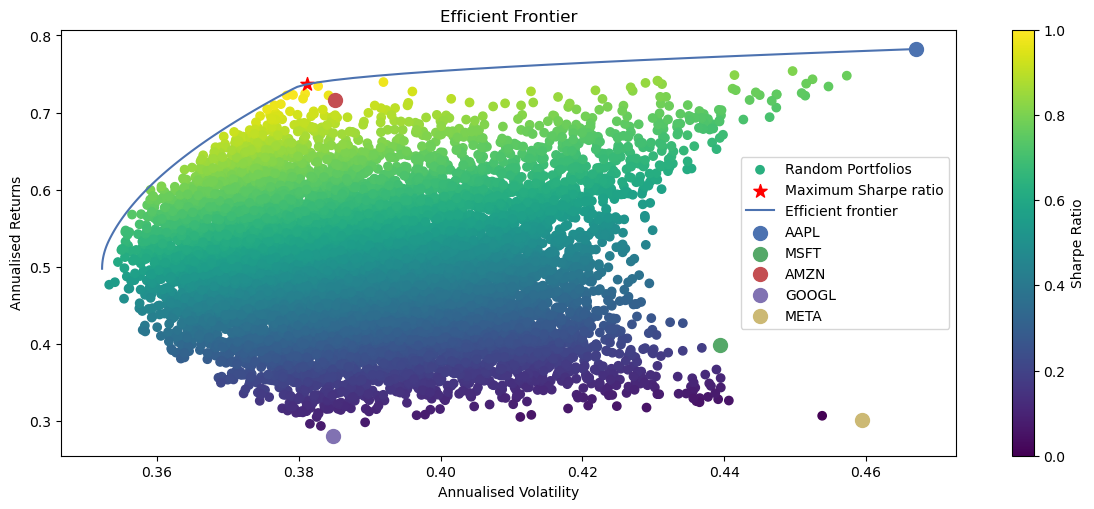

OrderedDict([('AAPL', 0.31472), ('AMZN', 0.68528), ('GOOGL', 0.0), ('META', 0.0), ('MSFT', 0.0)])
Expected annual return: 73.7%
Annual volatility: 38.1%
Sharpe Ratio: 1.88
Expected annual return: 0.74
Annual volatility: 0.38
Sharpe Ratio: 1.88


In [82]:
import numpy as np
import matplotlib.pyplot as plt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
import yfinance as yf

# Initialise Plot
plt.figure(figsize=(12, 5))

# Fetch historical price data
tickers = ["AAPL", "MSFT", "AMZN", "GOOGL", "META"]
prices = yf.download(tickers, start="2020-01-01", end="2021-01-01")["Adj Close"]

# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(prices)
S = risk_models.sample_cov(prices)

# Set up the Efficient Frontier object
ef = EfficientFrontier(mu, S)

# Calculate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
vols = np.sqrt(np.diag(w @ S @ w.T))
sharpes = rets / vols

# Plotting random portfolios
plt.scatter(vols, rets, c=sharpes, cmap='viridis', label='Random Portfolios')

# Find the maximum Sharpe ratio portfolio
ef_max_sharpe = EfficientFrontier(mu, S)
sharpe_pwt = ef_max_sharpe.max_sharpe()
ret_sharpe, vol_sharpe, _ = ef_max_sharpe.portfolio_performance()
plt.scatter(vol_sharpe, ret_sharpe, marker='*', color='r', s=100, label='Maximum Sharpe ratio')

# Plot the efficient frontier
plotting.plot_efficient_frontier(ef, ax=plt.gca(), show_assets=False)

# Highlight the assets
for ticker in tickers:
    plt.scatter(np.sqrt(S.loc[ticker, ticker]), mu[ticker], marker='o', s=100, label=ticker)
    


# Show the plot
plt.title('Efficient Frontier')
plt.xlabel('Annualised Volatility')
plt.ylabel('Annualised Returns')
plt.legend()
plt.colorbar(label='Sharpe Ratio')
plt.show()

# Recreate the EfficientFrontier object to find the maximum Sharpe portfolio weights
ef = EfficientFrontier(mu, S)
raw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)

# Calculate the expected performance 
performance = ef.portfolio_performance(verbose=True)


# Print
print(f"Expected annual return: {performance[0]:.2f}")
print(f"Annual volatility: {performance[1]:.2f}")
print(f"Sharpe Ratio: {performance[2]:.2f}")

[*********************100%***********************]  5 of 5 completed
HRP Weights:
OrderedDict([('AAPL', 0.05035861713988226), ('AMZN', 0.07957442702038603), ('GOOGL', 0.7724896763877956), ('META', 0.01575790631271125), ('MSFT', 0.08181937313922476)])


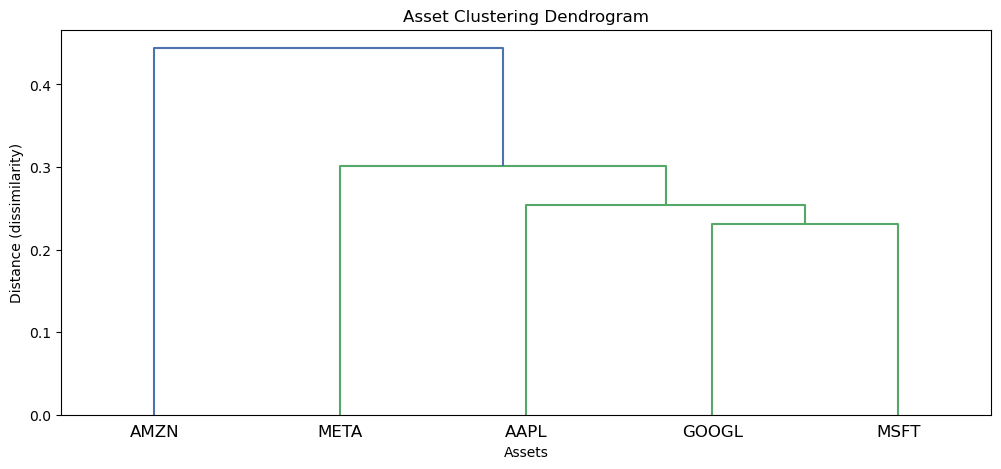

[*********************100%***********************]  5 of 5 completed
Iteration 1:
               AAPL      MSFT     GOOGL  AMZN-META
AAPL       0.000000  0.339364  0.316193   0.284200
MSFT       0.339364  0.000000  0.343495   0.306235
GOOGL      0.316193  0.343495  0.000000   0.293101
AMZN-META  0.284200  0.306235  0.293101   0.000000


Iteration 2:
                    MSFT     GOOGL  AAPL-AMZN-META
MSFT            0.000000  0.343495        0.322800
GOOGL           0.343495  0.000000        0.304647
AAPL-AMZN-META  0.322800  0.304647        0.000000


Iteration 3:
                          MSFT  GOOGL-AAPL-AMZN-META
MSFT                  0.000000              0.333147
GOOGL-AAPL-AMZN-META  0.333147              0.000000


Iteration 4:
                           MSFT-GOOGL-AAPL-AMZN-META
MSFT-GOOGL-AAPL-AMZN-META                        0.0




In [114]:
import yfinance as yf
from pypfopt import HRPOpt
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import yfinance as yf
from scipy.spatial.distance import pdist, squareform

# Fetch historical price data
tickers = ["AAPL", "MSFT", "AMZN", "GOOGL", "META"]
prices = yf.download(tickers, start="2020-01-01", end="2021-01-01")["Adj Close"]

# Apply Hierarchical Risk Parity model
hrp = HRPOpt(prices)
hrp_weights = hrp.optimize()

# Output the HRP weights
print("HRP Weights:")
print(hrp_weights)

# Compute the correlation matrix
corr_matrix = prices.pct_change().dropna().corr()

# Calculate the linkage matrix for dendrogram
link = linkage(corr_matrix, 'single')

# Plot the dendrogram
plt.figure(figsize=(12, 5))
dendrogram(link, labels=prices.columns)
plt.title("Asset Clustering Dendrogram")
plt.xlabel("Assets")
plt.ylabel("Distance (dissimilarity)")
plt.show()



# Fetch historical price data
tickers = ["AAPL", "MSFT", "AMZN", "GOOGL", "META"]
prices = yf.download(tickers, start="2020-01-01", end="2021-01-01")["Adj Close"]

# Compute the returns and the initial distance matrix
returns = prices.pct_change().dropna()
dist_matrix = squareform(pdist(returns.T, metric='euclidean'))

# Convert the distance matrix to a DataFrame for ease of manipulation
dist_df = pd.DataFrame(dist_matrix, index=tickers, columns=tickers)

# Custom hierarchical clustering
for i in range(len(tickers) - 1):
    print(f"Iteration {i + 1}:")

    # Find the pair with the smallest distance
    np.fill_diagonal(dist_df.values, np.inf)  # Ignore self-distances
    min_dist = np.min(dist_df.values)
    pair_to_merge = np.unravel_index(np.argmin(dist_df.values, axis=None), dist_df.shape)

    # Merge the pair in the distance matrix
    new_row = new_col = (dist_df.iloc[pair_to_merge[0]] + dist_df.iloc[pair_to_merge[1]]) / 2
    new_label = dist_df.index[pair_to_merge[0]] + "-" + dist_df.index[pair_to_merge[1]]

    # Drop the old rows/columns and add the new row/column
    dist_df = dist_df.append(pd.Series(new_row, name=new_label))
    dist_df.drop(index=[dist_df.index[pair_to_merge[0]], dist_df.index[pair_to_merge[1]]], 
                 columns=[dist_df.columns[pair_to_merge[0]], dist_df.columns[pair_to_merge[1]]], 
                 inplace=True)
    dist_df[new_label] = new_col
    
    # replace all nans and inf with 0
    dist_df = dist_df.replace([np.inf, np.nan], 0)

    # Print the updated distance matrix
    print(dist_df)
    print("\n")




[*********************100%***********************]  5 of 5 completed
Iteration 1:
               AAPL      MSFT     GOOGL  AMZN-META
AAPL       0.000000  0.339364  0.316193   0.284199
MSFT       0.339364  0.000000  0.343495   0.306235
GOOGL      0.316193  0.343495  0.000000   0.293101
AMZN-META  0.284199  0.306235  0.293101   0.000000


Iteration 2:
                    MSFT     GOOGL  AAPL-AMZN-META
MSFT            0.000000  0.343495        0.322800
GOOGL           0.343495  0.000000        0.304647
AAPL-AMZN-META  0.322800  0.304647        0.000000


Iteration 3:
                          MSFT  GOOGL-AAPL-AMZN-META
MSFT                  0.000000              0.333147
GOOGL-AAPL-AMZN-META  0.333147              0.000000


Iteration 4:
                           MSFT-GOOGL-AAPL-AMZN-META
MSFT-GOOGL-AAPL-AMZN-META                        0.0




In [115]:
# credit : https://gautier.marti.ai/qfin/2018/10/02/hierarchical-risk-parity-part-1.html

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.linalg import block_diag
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt

# Set the number of alphas (factors) and observations
nb_alphas = 250
nb_observations = int(0.3 * 252)  # Approximately 30% of a trading year

# Building a hierarchical block diagonal correlation matrix
# Creating blocks representing different investment styles
quality = 0.6 * np.ones((nb_alphas // 6, nb_alphas // 6))  # Quality style block
value = 2.4 * np.ones((nb_alphas // 2, nb_alphas // 2))    # Value style block
momentum = 2.6 * np.ones((int(nb_alphas * (1 - 1/6 - 1/2) + 1),
                         int(nb_alphas * (1 - 1/6 - 1/2) + 1)))  # Momentum style block

# Correlation matrix between momentum and value styles
correl_mom_value = -1.2 * np.ones((int(nb_alphas * (1 - 1/6)) + 1,
                                  int(nb_alphas * (1 - 1/6)) + 1))

# Combine the blocks to form the complete correlation matrix
correl = (block_diag(quality, correl_mom_value) +
          block_diag(quality, momentum, value)) / 3
np.fill_diagonal(correl, 1)  # Fill the diagonal with ones for self-correlation

# Define mean returns and volatilities for each alpha
mean_returns = np.zeros(nb_alphas)  # Assuming zero mean returns for simplicity
volatilities = ([np.sqrt(0.1 / np.sqrt(252))] * (nb_alphas // 3) + 
                [np.sqrt(0.3 / np.sqrt(252))] * (nb_alphas - nb_alphas // 3 - nb_alphas // 6) + 
                [np.sqrt(0.5 / np.sqrt(252))] * (nb_alphas // 6))  # Different volatilities per style

# Calculate the covariance matrix
covar = np.multiply(correl, np.outer(np.array(volatilities), np.array(volatilities)))
covar = pd.DataFrame(covar)  # Convert to a pandas DataFrame for easier handling


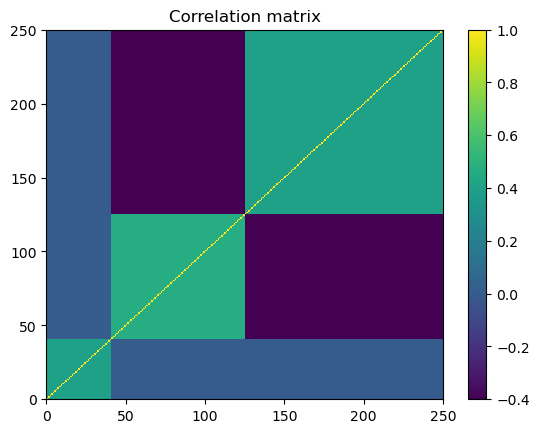

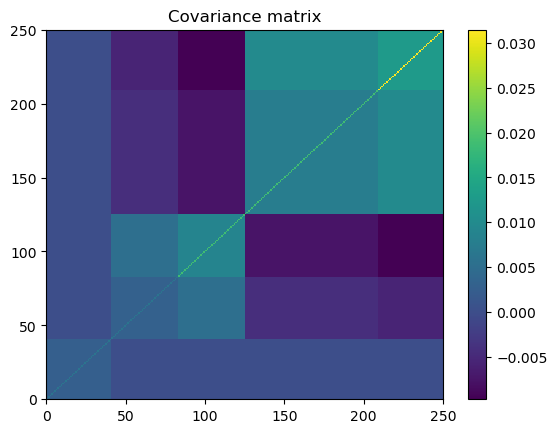

In [86]:
plt.pcolormesh(correl)
plt.colorbar()
plt.title('Correlation matrix')
plt.show()

plt.pcolormesh(covar)
plt.colorbar()
plt.title('Covariance matrix')
plt.show()

In [87]:
alphas_returns = np.random.multivariate_normal(
    mean_returns, cov=covar, size=nb_observations)

alphas_returns = pd.DataFrame(alphas_returns)

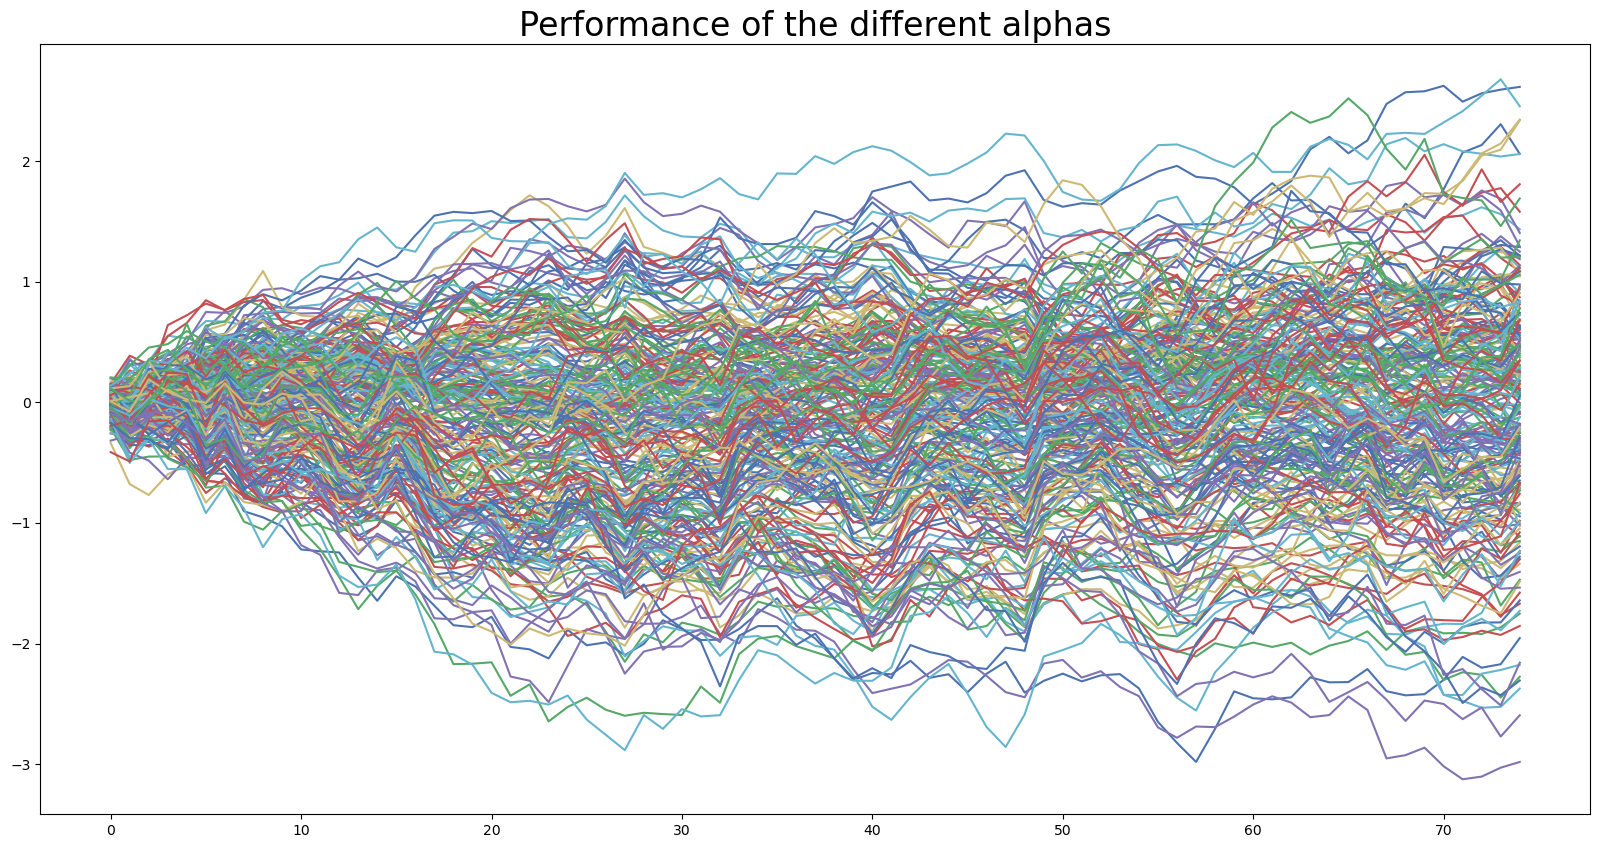

In [88]:
plt.figure(figsize=(20, 10))
plt.plot(alphas_returns.cumsum())
plt.title('Performance of the different alphas', fontsize=24)
plt.show()

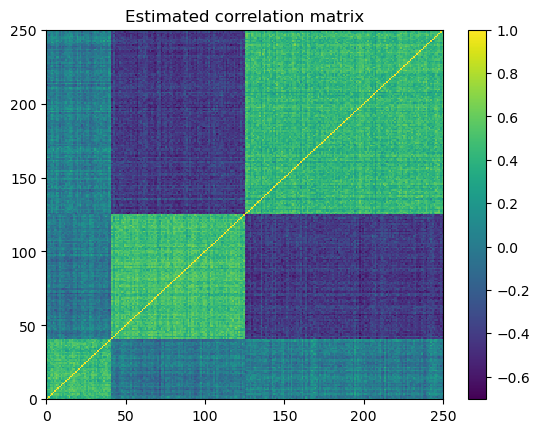

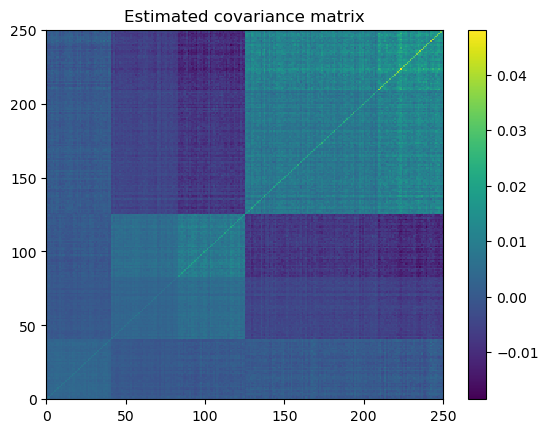

In [89]:
estimate_correl = alphas_returns.corr(method='pearson')
estimate_covar = alphas_returns.cov()
plt.pcolormesh(estimate_correl)
plt.colorbar()
plt.title('Estimated correlation matrix')
plt.show()

plt.pcolormesh(estimate_covar)
plt.colorbar()
plt.title('Estimated covariance matrix')
plt.show()

In [90]:
def seriation(Z, N, cur_index):
    """Returns the order implied by a hierarchical tree (dendrogram).
    
       :param Z: A hierarchical tree (dendrogram).
       :param N: The number of points given to the clustering process.
       :param cur_index: The position in the tree for the recursive traversal.
       
       :return: The order implied by the hierarchical tree Z.
    """
    if cur_index < N:
        return [cur_index]
    else:
        left = int(Z[cur_index - N, 0])
        right = int(Z[cur_index - N, 1])
        return (seriation(Z, N, left) + seriation(Z, N, right))

    
def compute_serial_matrix(dist_mat, method="ward"):
    """Returns a sorted distance matrix.
    
       :param dist_mat: A distance matrix.
       :param method: A string in ["ward", "single", "average", "complete"].
        
        output:
            - seriated_dist is the input dist_mat,
              but with re-ordered rows and columns
              according to the seriation, i.e. the
              order implied by the hierarchical tree
            - res_order is the order implied by
              the hierarhical tree
            - res_linkage is the hierarhical tree (dendrogram)
        
        compute_serial_matrix transforms a distance matrix into 
        a sorted distance matrix according to the order implied 
        by the hierarchical tree (dendrogram)
    """
    N = len(dist_mat)
    flat_dist_mat = squareform(dist_mat)
    res_linkage = linkage(flat_dist_mat, method=method)
    res_order = seriation(res_linkage, N, N + N - 2)
    seriated_dist = np.zeros((N, N))
    a,b = np.triu_indices(N, k=1)
    seriated_dist[a,b] = dist_mat[[res_order[i] for i in a], [res_order[j] for j in b]]
    seriated_dist[b,a] = seriated_dist[a,b]
    
    return seriated_dist, res_order, res_linkage

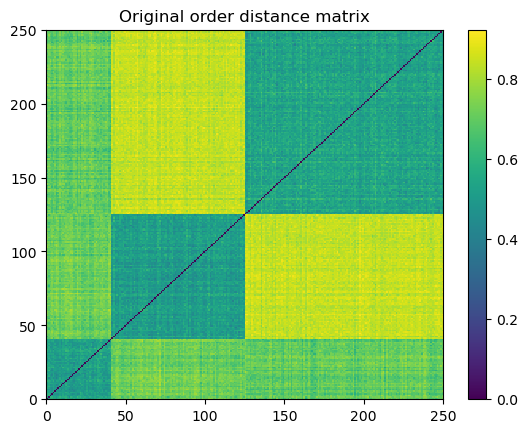

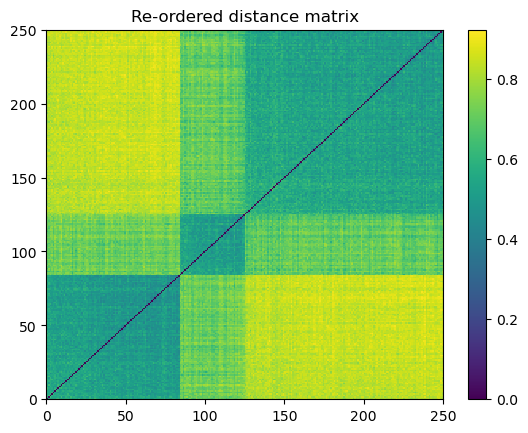

In [91]:
distances = np.sqrt((1 - estimate_correl) / 2)
ordered_dist_mat, res_order, res_linkage = compute_serial_matrix(distances.values, method='single')

plt.pcolormesh(distances)
plt.colorbar()
plt.title('Original order distance matrix')
plt.show()

plt.pcolormesh(ordered_dist_mat)
plt.colorbar()
plt.title('Re-ordered distance matrix')
plt.show()

In [92]:
def compute_HRP_weights(covariances, res_order):
    weights = pd.Series(1, index=res_order)
    clustered_alphas = [res_order]

    while len(clustered_alphas) > 0:
        clustered_alphas = [cluster[start:end] for cluster in clustered_alphas
                            for start, end in ((0, len(cluster) // 2),
                                               (len(cluster) // 2, len(cluster)))
                            if len(cluster) > 1]
        for subcluster in range(0, len(clustered_alphas), 2):
            left_cluster = clustered_alphas[subcluster]
            right_cluster = clustered_alphas[subcluster + 1]

            left_subcovar = covariances[left_cluster].loc[left_cluster]
            inv_diag = 1 / np.diag(left_subcovar.values)
            parity_w = inv_diag * (1 / np.sum(inv_diag))
            left_cluster_var = np.dot(parity_w, np.dot(left_subcovar, parity_w))

            right_subcovar = covariances[right_cluster].loc[right_cluster]
            inv_diag = 1 / np.diag(right_subcovar.values)
            parity_w = inv_diag * (1 / np.sum(inv_diag))
            right_cluster_var = np.dot(parity_w, np.dot(right_subcovar, parity_w))

            alloc_factor = 1 - left_cluster_var / (left_cluster_var + right_cluster_var)

            weights[left_cluster] *= alloc_factor
            weights[right_cluster] *= 1 - alloc_factor
            
    return weights


def compute_MV_weights(covariances):
    inv_covar = np.linalg.inv(covariances)
    u = np.ones(len(covariances))
    
    return np.dot(inv_covar, u) / np.dot(u, np.dot(inv_covar, u))


def compute_RP_weights(covariances):
    weights = (1 / np.diag(covariances)) 
    
    return weights / sum(weights)


def compute_unif_weights(covariances):
    
    return [1 / len(covariances) for i in range(len(covariances))]

In [93]:
# in-sample HRP annualized volatility
# using estimated covariance

HRP_weights = compute_HRP_weights(estimate_covar, res_order)

print(round((HRP_weights * alphas_returns).sum(axis=1).std() * np.sqrt(252),
            2))

0.41


In [94]:
# using original covariance (not observed in practice)

HRP_weights = compute_HRP_weights(covar, res_order)

print(round((HRP_weights * alphas_returns).sum(axis=1).std() * np.sqrt(252),
            2))

0.42


In [95]:
# in-sample 1 / N annualized volatility
unif_weights = compute_unif_weights(estimate_covar)

print(round((unif_weights * alphas_returns).sum(axis=1).std() * np.sqrt(252),
            2))

0.49


In [96]:
# in-sample naive risk parity normalized(1 / vol) volatility

# using estimated covariance matrix
RP_weights = compute_RP_weights(estimate_covar)

print(round((RP_weights * alphas_returns).sum(axis=1).std() * np.sqrt(252),
      2))

0.31
